In [19]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')


In [20]:
def clean_fuel_consumption(fuel_type, value):
    """
    Extrahiert den Verbrauch in l/100 km als float.
    Alle anderen Einheiten und ungültige Werte werden zu NaN.
    """
    if fuel_type in ['Diesel', 'Petrol', 'Hybrid', 'LPG', 'Electric', 'Diesel Hybrid', 'Other', 'Unknown', 'Ethanol']:
        if pd.isna(value) or 'l/100' not in str(value):
            return np.nan
        try:
            return float(str(value).split(' ')[0].replace(',', '.'))
        except:
            return np.nan

    elif fuel_type == 'CNG':
        if 'kg/100' in str(value):
            try:
                return round(float(str(value).split(' ')[0].replace(',', '.')) / 0.18, 2)
            except:
                return np.nan
        elif 'l/100' in str(value):
            try:
                return float(str(value).split(' ')[0].replace(',', '.'))
            except:
                return np.nan
        else:
            return np.nan
    elif fuel_type == 'Hydrogen':
        if 'kg/100' in str(value):
            try:
                kg = float(str(value).split()[0].replace(',', '.'))
                return round(kg * 33.33 / 8.6, 2)
            except:
                return np.nan
        else:
            return np.nan
        
    return np.nan

def preprocessing_pipeline(df):


    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)

    # Nur relevante fuel types
 #   df = df[df['fuel_type'].isin(['Diesel', 'Petrol', 'Hybrid', 'LPG', 'Electric', 'CNG', 'Diesel Hybrid', 'Unknown', 'Hydrogen'])].reset_index(drop=True)

    # Fuel consumption in l/100 km bereinigen
    df['fuel_consumption_l_100km'] = df.apply(
    lambda row: clean_fuel_consumption(row['fuel_type'], row['fuel_consumption_l_100km']),
    axis=1
    )

    # E-Autos: Verbrauch auf 0 setzen, Reichweite extrahieren
    e_mask = df['fuel_type'] == 'Electric'
    df.loc[e_mask, 'fuel_consumption_l_100km'] = 0.0
    # Extrahiere Reichweite aus fuel_consumption_g_km
    range_mask = e_mask & df['fuel_consumption_g_km'].astype(str).str.contains(r'km Reichweite', na=False)
    df.loc[range_mask, 'electric_range'] = (
        df.loc[range_mask, 'fuel_consumption_g_km']
          .astype(str)
          .str.extract(r'(\d+)', expand=False)
          .astype(float)
    )
    # Nicht-Elektro auf 0
    df.loc[~e_mask, 'electric_range'] = 0.0

    # Numerische Typen setzen
    for col in ['power_ps', 'power_kw']:
        df[col] = df[col].astype(float)
    df['mileage_in_km'] = pd.to_numeric(df['mileage_in_km'], errors='coerce')
    df['price_in_euro'] = pd.to_numeric(df['price_in_euro'], errors='coerce')
    df['year'] = pd.to_numeric(df['year'], errors='coerce')

    # Datum in numerische Merkmale umwandeln
    df['registration_date'] = pd.to_datetime(df['registration_date'], format='%m/%Y', errors='coerce')
    df['registration_month'] = df['registration_date'].dt.month

    return df

In [21]:
df  = pd.read_csv('../data.csv')

In [22]:
yearsToFilter = list(df['year'].unique()[:29])  # wegen Scraping Fehler
filt = [val in yearsToFilter for val in df['year']]
df = df[filt]

In [23]:
df = preprocessing_pipeline(df)

In [24]:
numeric  = list(df.select_dtypes('number').columns)

In [35]:
df[(df['fuel_type'] != 'Electric')][numeric]

,year,price_in_euro,power_kw,power_ps,fuel_consumption_l_100km,mileage_in_km,electric_range,registration_month
0,1995,1300,148.0,201.0,10.9,160500.0,0.0,10
1,1995,24900,191.0,260.0,NaN,190000.0,0.0,2
2,1995,5900,110.0,150.0,NaN,129000.0,0.0,2
3,1995,4900,110.0,150.0,9.5,189500.0,0.0,7
4,1996,17950,132.0,179.0,7.2,96127.0,0.0,11
...,...,...,...,...,...,...,...,...
251073,2023,54500,145.0,197.0,5.6,5900.0,0.0,3
251074,2023,57990,192.0,261.0,NaN,1229.0,0.0,4
251075,2023,89690,173.0,235.0,7.6,4900.0,0.0,3
251076,2023,61521,145.0,197.0,4.7,1531.0,0.0,5


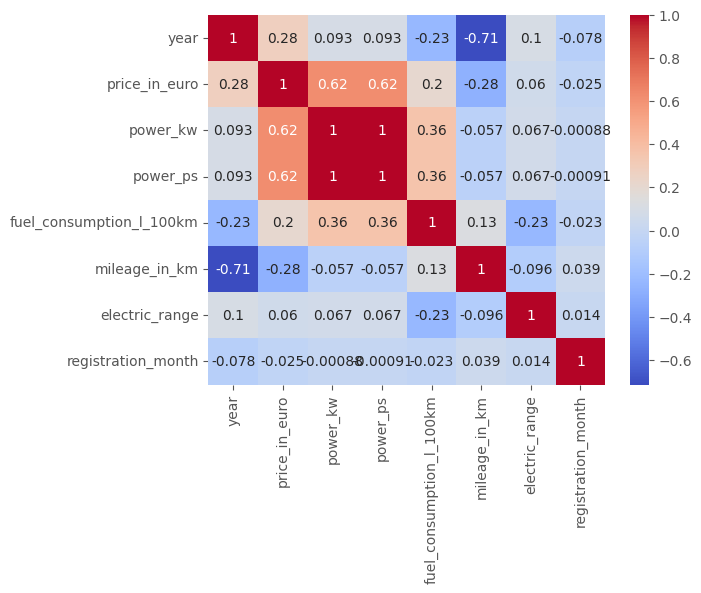

In [25]:
sns.heatmap(df[numeric].corr(), annot=True, cmap='coolwarm')
plt.show()

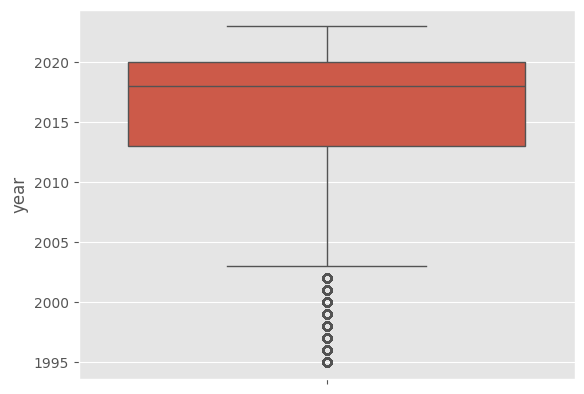

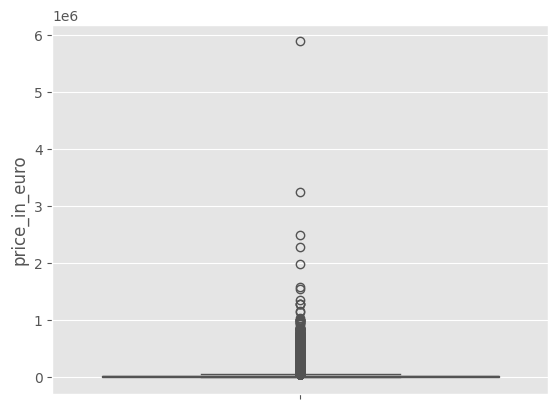

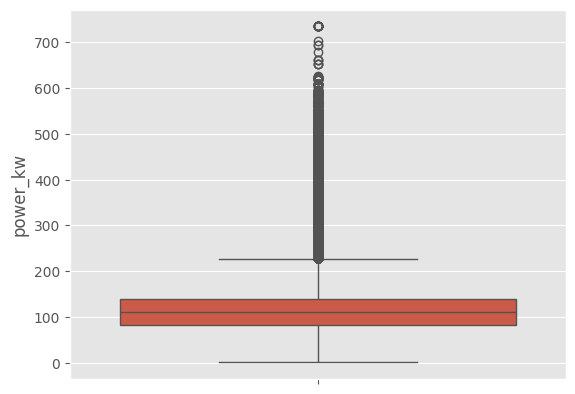

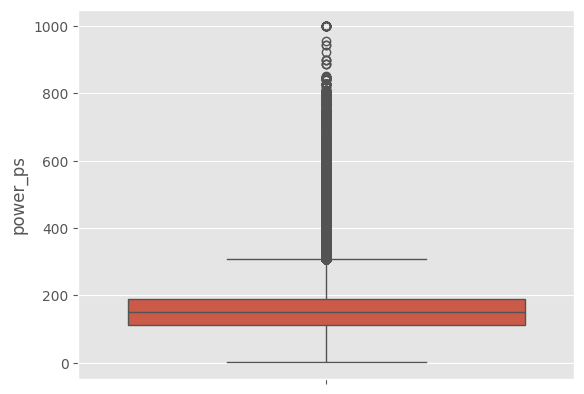

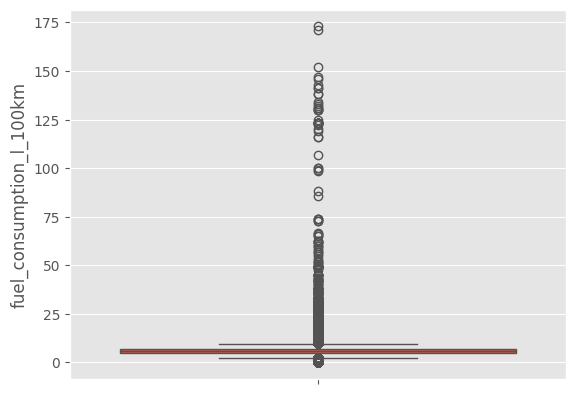

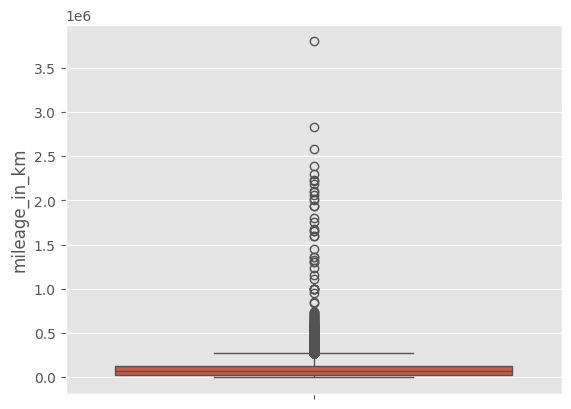

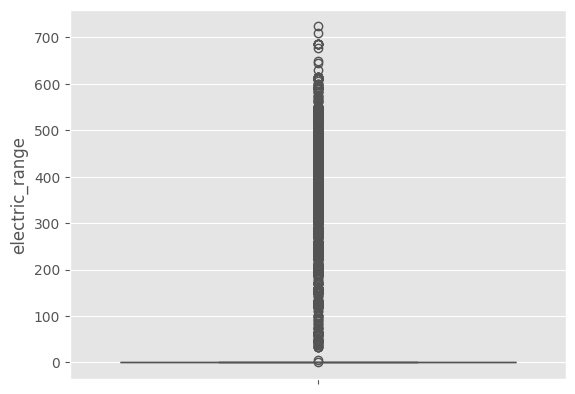

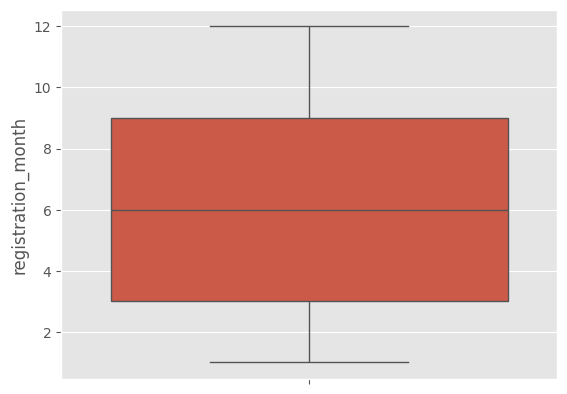

In [26]:
for feature in numeric:
    sns.boxplot(y= feature, data= df)
    plt.show()

In [27]:
df.columns

Index(['brand', 'model', 'color', 'registration_date', 'year', 'price_in_euro',
       'power_kw', 'power_ps', 'transmission_type', 'fuel_type',
       'fuel_consumption_l_100km', 'fuel_consumption_g_km', 'mileage_in_km',
       'offer_description', 'electric_range', 'registration_month'],
      dtype='object')

In [28]:
df.sort_values(by = 'fuel_consumption_l_100km', ascending= False)

,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description,electric_range,registration_month
183867,seat,SEAT Tarraco,grey,2020-08-01,2020,25690,110.0,150.0,Manual,Petrol,173.0,173 g/km,28400.0,1.5 Style TSI BMT 7 Sitze Navi Klima,0.0,8
203327,skoda,Skoda Karoq,white,2023-04-01,2023,40790,140.0,190.0,Automatic,Petrol,171.0,171 g/km,10.0,2.0TSI DSG 4x4 Sportline Navi DCC Kamera,0.0,4
133390,mini,MINI Cooper S,silver,2022-07-01,2022,27990,131.0,178.0,Automatic,Petrol,152.0,128 g/km,24000.0,"Cabrio Aut. Yours Trim, RFK, SHZ, Komfortzugan...",0.0,7
183844,seat,SEAT Ateca,grey,2020-09-01,2020,21990,110.0,150.0,Manual,Diesel,147.0,147 g/km,29000.0,2.0 Style TDI BMT Klima Radio Alu,0.0,9
239041,volkswagen,Volkswagen T-Roc,red,2019-03-01,2019,18990,85.0,116.0,Manual,Diesel,146.0,146 g/km,40800.0,1.6 Comfortline StyleTDI BMT Navi Klima,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251032,volvo,Volvo XC60,black,2023-03-01,2023,73950,228.0,310.0,Automatic,Hybrid,NaN,75 km Reichweite,4200.0,Recharge T8 AWD Plug-in Hybrid Ultimate Bright...,0.0,3
251045,volvo,Volvo XC60,black,2023-03-01,2023,74970,335.0,455.0,Automatic,Hybrid,NaN,77 km Reichweite,8000.0,Recharge T8 Plus Bright Standheizung/LED,0.0,3
251046,volvo,Volvo XC40,black,2023-02-01,2023,42990,120.0,163.0,Automatic,Petrol,NaN,- (g/km),2500.0,B3 Core LED*ACC*StdHzg*RFK,0.0,2
251074,volvo,Volvo XC40,white,2023-04-01,2023,57990,192.0,261.0,Automatic,Hybrid,NaN,43 km Reichweite,1229.0,Plus Bright T5 Recharge Intellisafe*Surround+P...,0.0,4


In [29]:
df[df['fuel_consumption_g_km'] == df['fuel_consumption_l_100km']].sort_values(by = 'fuel_consumption_l_100km', ascending= False)  

,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description,electric_range,registration_month


In [30]:
df.query('fuel_consumption_l_100km > 30 & fuel_consumption_l_100km != fuel_consumption_g_km')

,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description,electric_range,registration_month
12956,audi,Audi A4,blue,2017-12-01,2017,16980,125.0,170.0,Automatic,CNG,33.33,137 g/km,165000.0,Avant g-tron*S-TRONIC*LED*NAVI*AHK*1.HAND*,0.0,12
13297,audi,Audi A5,grey,2017-12-01,2017,28950,125.0,170.0,Automatic,CNG,33.33,106 g/km,51600.0,Sportback 2.0TFSI g-tron*MATRIX-LED*LEDER,0.0,12
13517,audi,Audi A4,grey,2017-11-01,2017,22999,125.0,170.0,Automatic,CNG,33.33,137 g/km,117300.0,Avant G-tron Design*BENZIN/CNG*TOP*GARANTIE*,0.0,11
14052,audi,Audi A4,black,2017-11-01,2017,21500,125.0,170.0,Manual,CNG,34.44,- (g/km),77500.0,A4 Avant g-tron 2.0 TFSI sport,0.0,11
14597,audi,Audi A5,blue,2018-07-01,2018,27900,125.0,170.0,Automatic,CNG,33.33,135 g/km,29863.0,SB g-tron sport*MMI-PLUS*So.+Wi. Räder*1.Hand,0.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239041,volkswagen,Volkswagen T-Roc,red,2019-03-01,2019,18990,85.0,116.0,Manual,Diesel,146.00,146 g/km,40800.0,1.6 Comfortline StyleTDI BMT Navi Klima,0.0,3
239613,volkswagen,Volkswagen Golf,black,2019-11-01,2019,16690,85.0,116.0,Manual,Diesel,130.00,130 g/km,37500.0,Vll 1.6 Trendline BMT TDI 4Trg Navi Klima,0.0,11
240568,volkswagen,Volkswagen up!,yellow,2020-12-01,2020,13490,50.0,68.0,Manual,CNG,32.22,105 g/km,22700.0,"eco up! 1.0 EcoFuel, Benzin / CNG Temp BT SHz",0.0,12
241526,volkswagen,Volkswagen Golf Variant,silver,2020-08-01,2020,22990,110.0,150.0,Automatic,Diesel,143.00,143 g/km,33600.0,2.0 United BMT TDI DSG Navi Klima,0.0,8


In [31]:
df.query('model == "Bentley Continental GT"')

,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description,electric_range,registration_month
22896,bentley,Bentley Continental GT,green,2005-09-01,2005,57999,411.0,559.0,Automatic,Petrol,16.6,396 g/km,39000.0,C Mulliner in absolutem Neuzustand Spruce Green,0.0,9
22899,bentley,Bentley Continental GT,black,2005-10-01,2005,54949,412.0,560.0,Automatic,Petrol,17.1,410 g/km,59000.0,Mansory GT 63 Unikat 22 Zoll TOP!,0.0,10
22901,bentley,Bentley Continental GT,silver,2005-06-01,2005,35990,411.0,559.0,Automatic,Petrol,17.1,410 g/km,105990.0,6.0 W12|LEDER|MASSAGE|Keyless-Go|,0.0,6
22907,bentley,Bentley Continental GT,white,2006-06-01,2006,48900,411.0,559.0,Automatic,Petrol,17.1,410 g/km,83900.0,MANSORY-UMBAU TOP,0.0,6
22915,bentley,Bentley Continental GT,black,2007-05-01,2007,49999,411.0,559.0,Automatic,Petrol,17.1,410 g/km,54999.0,MANSORY-OPTIK*FACELIFT-UMBAU*,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23371,bentley,Bentley Continental GT,grey,2023-06-01,2023,299900,404.0,549.0,Automatic,Petrol,11.3,263 g/km,3600.0,V8 Azure // BENTLEY DÜSSELDORF,0.0,6
23380,bentley,Bentley Continental GT,grey,2023-01-01,2023,274900,404.0,549.0,Automatic,Petrol,11.3,263 g/km,3985.0,V8 Azure // BENTLEY DÜSSELDORF,0.0,1
23387,bentley,Bentley Continental GT,green,2023-04-01,2023,285500,405.0,551.0,Automatic,Petrol,11.3,263 g/km,3100.0,S V8 - MY23 - BENTLEY BERLIN -,0.0,4
23388,bentley,Bentley Continental GT,green,2023-02-01,2023,285450,405.0,551.0,Automatic,Petrol,11.3,263 g/km,4000.0,V8 #On STOCK #,0.0,2


In [32]:
df.query('fuel_consumption_l_100km > 22').sort_values(by = 'fuel_consumption_l_100km', ascending= True)

,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description,electric_range,registration_month
52020,ferrari,Ferrari 456,silver,2000-05-01,2000,62500,325.0,442.0,Automatic,Petrol,22.20,- (g/km),73590.0,456M GTA,0.0,5
52006,ferrari,Ferrari 456,blue,1998-05-01,1998,90000,325.0,442.0,Automatic,Petrol,22.20,520 g/km,7500.0,GTA,0.0,5
183580,seat,SEAT Arona,blue,2020-08-01,2020,25288,66.0,90.0,Manual,CNG,22.22,"104,5 g/km",41900.0,1.0 TGI FR KLIMA / ACC / NAVI / LED / ALCANTARA,0.0,8
185436,seat,SEAT Arona,red,2021-01-01,2021,12677,66.0,90.0,Manual,CNG,22.22,102 g/km,39332.0,1.0 TGI STYLE KLIMA ALU DAB+ Bluetooth,0.0,1
185458,seat,SEAT Arona,red,2021-06-01,2021,15055,66.0,90.0,Manual,CNG,22.22,102 g/km,27101.0,1.0 TGI STYLE CAM LED-TAGFAHRLICHT LM16,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239041,volkswagen,Volkswagen T-Roc,red,2019-03-01,2019,18990,85.0,116.0,Manual,Diesel,146.00,146 g/km,40800.0,1.6 Comfortline StyleTDI BMT Navi Klima,0.0,3
183844,seat,SEAT Ateca,grey,2020-09-01,2020,21990,110.0,150.0,Manual,Diesel,147.00,147 g/km,29000.0,2.0 Style TDI BMT Klima Radio Alu,0.0,9
133390,mini,MINI Cooper S,silver,2022-07-01,2022,27990,131.0,178.0,Automatic,Petrol,152.00,128 g/km,24000.0,"Cabrio Aut. Yours Trim, RFK, SHZ, Komfortzugan...",0.0,7
203327,skoda,Skoda Karoq,white,2023-04-01,2023,40790,140.0,190.0,Automatic,Petrol,171.00,171 g/km,10.0,2.0TSI DSG 4x4 Sportline Navi DCC Kamera,0.0,4


In [33]:
df_initial[(df_initial['model'] == 'SEAT Tarraco') & (df_initial['color'] == 'grey')]

df_initial.query('model == "SEAT Tarraco" & color == "grey" & year == "2020"')

NameError: name 'df_initial' is not defined